In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
from pydub import AudioSegment, effects

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

import optuna
from optuna.pruners import MedianPruner, PatientPruner

In [2]:
# Data from:
# Crowd-sourced Emotional Multimodal Actors Dataset (CREMA-D)
# Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
# Surrey Audio-Visual Expressed Emotion (SAVEE)
# Toronto Emotional Speech Set (TESS)

df = pd.read_csv('df.csv')
df.head()

,path,sex,emotion
0,./ravdess/Actor_16/03-01-05-01-02-01-16.wav,female,angry
1,./ravdess/Actor_16/03-01-06-01-02-02-16.wav,female,fear
2,./ravdess/Actor_16/03-01-06-02-01-02-16.wav,female,fear
3,./ravdess/Actor_16/03-01-05-02-01-01-16.wav,female,angry
4,./ravdess/Actor_16/03-01-07-01-01-01-16.wav,female,disgust


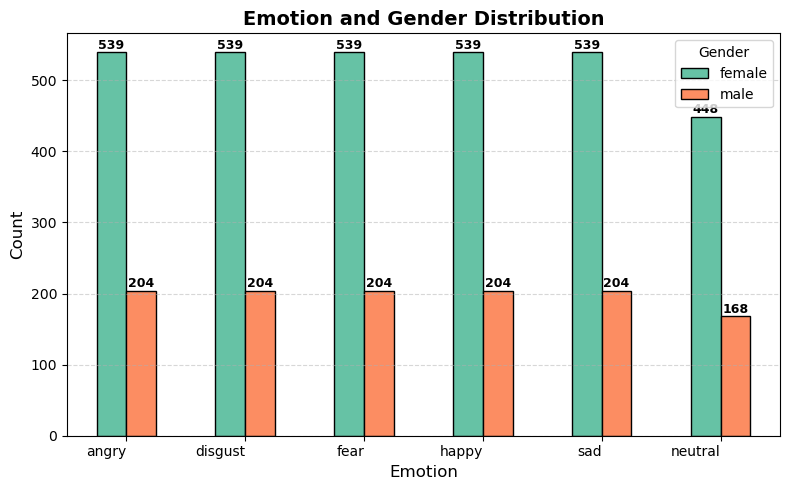

In [3]:
def plot_distribution(df, title='Emotion and Gender Distribution', figsize=(8,5), palette='Set2'):
    # Preparing count data
    count_df = df.groupby(['emotion', 'sex']).size().unstack(fill_value=0)
    
    # Sorting emotions alphabetically
    count_df = count_df.loc[count_df.sum(axis=1).sort_values(ascending=False).index]
    
    # Plot
    ax = count_df.plot(kind='bar', figsize=figsize, color=sns.color_palette(palette, n_colors=len(count_df.columns)), edgecolor='black')
    # Annotating counts on bars
    for p in ax.patches:
        height = int(p.get_height())
        if height > 0:
            ax.annotate(str(height), (p.get_x() + p.get_width() / 2., height + 1), 
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Labelling and styling
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0, ha='right')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
plot_distribution(df)

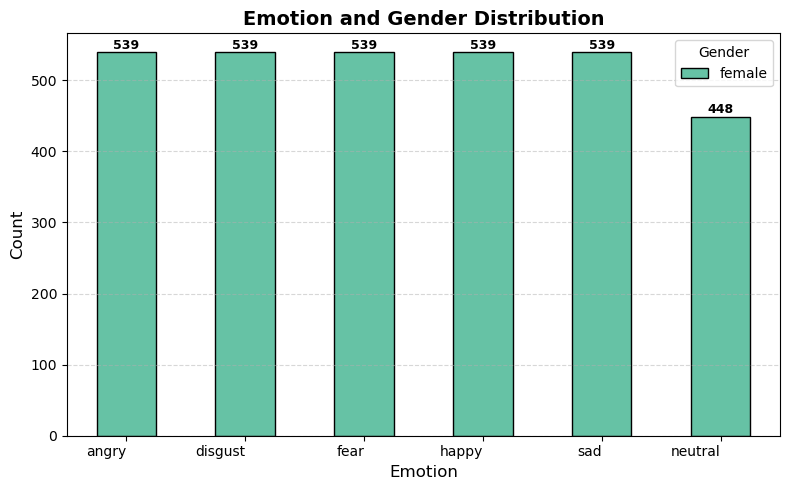

In [4]:
# Gender Specific Model
df = df[df['sex'] == 'female']
plot_distribution(df)

In [5]:
def plotWaveform(y, sr, title):
    plt.figure(figsize=(10,2), dpi=300)
    plt.title(title)
    librosa.display.waveshow(y, sr=sr, lw=0.1)
    plt.show()

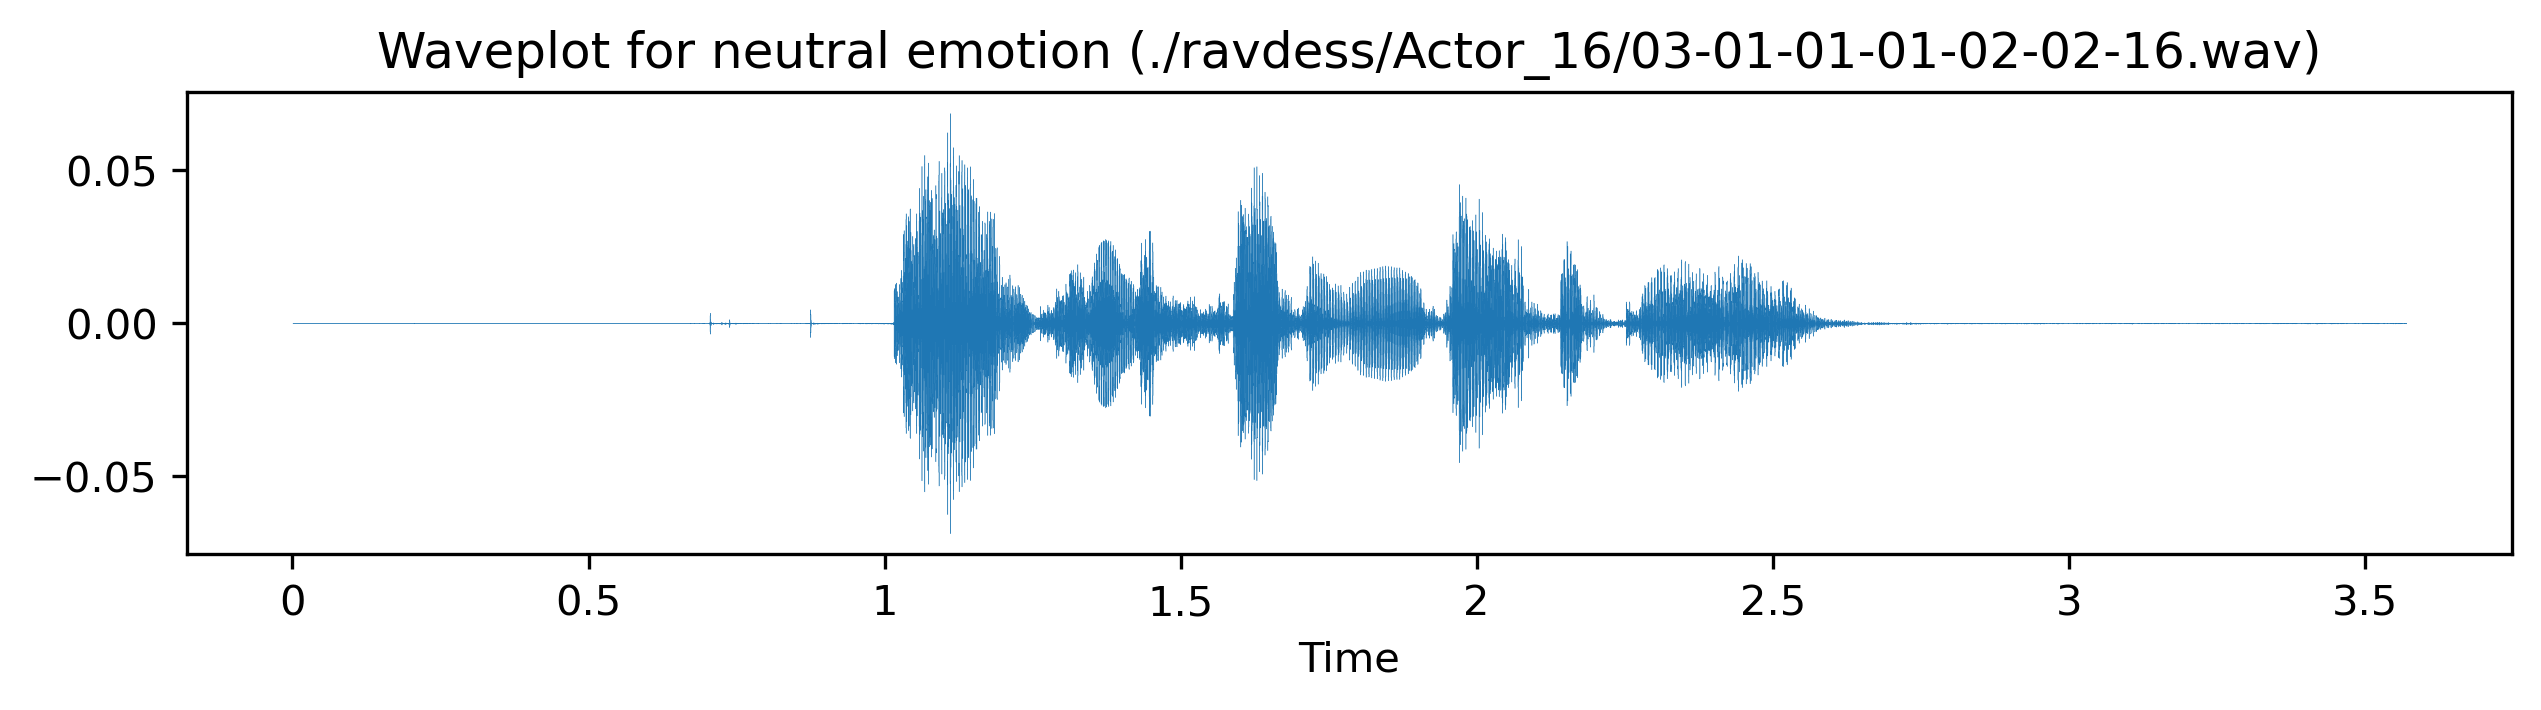

In [6]:
emotionLabel = 'neutral'

path = np.array(df.path[df.emotion == emotionLabel])[0]
title = f"Waveplot for {emotionLabel} emotion" + " (" + path + ")"
y, sr = librosa.load(path)

plotWaveform(y, sr, title)
Audio(path)

In [7]:
# Encoding labels

def encode(label):
    mapping = {
        'neutral': 0,
        'happy': 1,
        'sad': 2,
        'angry': 3,
        'fear': 4,
        'disgust': 5
    }
    return mapping[label]

In [8]:
# Initialize empty lists
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []


print("Loading saved features into memory...")

for row in tqdm(df.itertuples(index=False), total=len(df)):
    try:
        # Build relative .npy path
        relative_path = os.path.splitext(row.path.lstrip('./'))[0] + '.npy'

        # Full paths to feature files
        zcr_path = os.path.join("zcr", relative_path)
        rms_path = os.path.join("rms", relative_path)
        mfcc_path = os.path.join("mfccs", relative_path)

        # Load features
        zcr = np.load(zcr_path)    # (1, T)
        rms = np.load(rms_path)    # (1, T)
        mfccs = np.load(mfcc_path) # (13, T)

        # Append to respective lists
        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))

    except Exception as e:
        print(f"Failed to load features for {row.path}: {e}")

Loading saved features into memory...


100%|██████████| 3143/3143 [00:01<00:00, 2464.11it/s]


In [9]:
# Combine individual features (ZCR, RMS, MFCCs) into a single feature array (X).
# Each audio sample currently has ZCR (1, time_steps), RMS (1, time_steps), and MFCCs (13, time_steps).
# To train the model efficiently, we concatenate all features along the feature dimension so that each sample becomes a 
# single 2D array of shape (time_steps, 15 features).
# This results in a unified dataset X of shape (samples, time_steps, 15), which is ideal for input to models like CNNs, LSTMs, etc. 
# I also prepared the label array y (shape: samples, 1) for supervised learning.

X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),  # (samples, time_steps, 1)
    np.swapaxes(rms_list, 1, 2),  # (samples, time_steps, 1)
    np.swapaxes(mfccs_list, 1, 2) # (samples, time_steps, 13)
), axis=2).astype('float32')      # Final shape: (samples, time_steps, 15)

# Labels
y = np.expand_dims(np.array(emotion_list), axis=1).astype('int8')  # (samples, 1)

In [10]:
# Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=6)
y_val_cat = to_categorical(y_val, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

# **BASELINE MODEL**

In [77]:
# Define Conv1D Model

model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))  # 6 emotion classes


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
history = model.fit(X_train, y_train_cat,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_val, y_val_cat),
                    callbacks=[earlystop, reduce_lr],
                    verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\n Final Test Accuracy: {test_accuracy:.2%}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-03-18 19:33:00.143574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - categorical_accuracy: 0.1718 - loss: 17.2103 - val_categorical_accuracy: 0.2652 - val_loss: 2.4870 - learning_rate: 1.0000e-04
Epoch 2/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - categorical_accuracy: 0.2571 - loss: 5.4063 - val_categorical_accuracy: 0.3447 - val_loss: 1.6401 - learning_rate: 1.0000e-04
Epoch 3/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - categorical_accuracy: 0.3249 - loss: 2.7636 - val_categorical_accuracy: 0.5492 - val_loss: 1.1781 - learning_rate: 1.0000e-04
Epoch 4/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - categorical_accuracy: 0.4065 - loss: 1.8471 - val_categorical_accuracy: 0.5758 - val_loss: 1.0618 - learning_rate: 1.0000e-04
Epoch 5/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - categorical_accuracy: 0.5039 - loss: 1.3822 - val_categorical_accuracy: 0.6894 - val_loss: 0.9740 - learning_rate: 1.0000e-04
Epoch 6/200
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - categorical_accuracy: 0.5520 - loss: 1.1662 - val_categor

In [78]:
# Save Model
model.save("conv1dModel_female.keras")

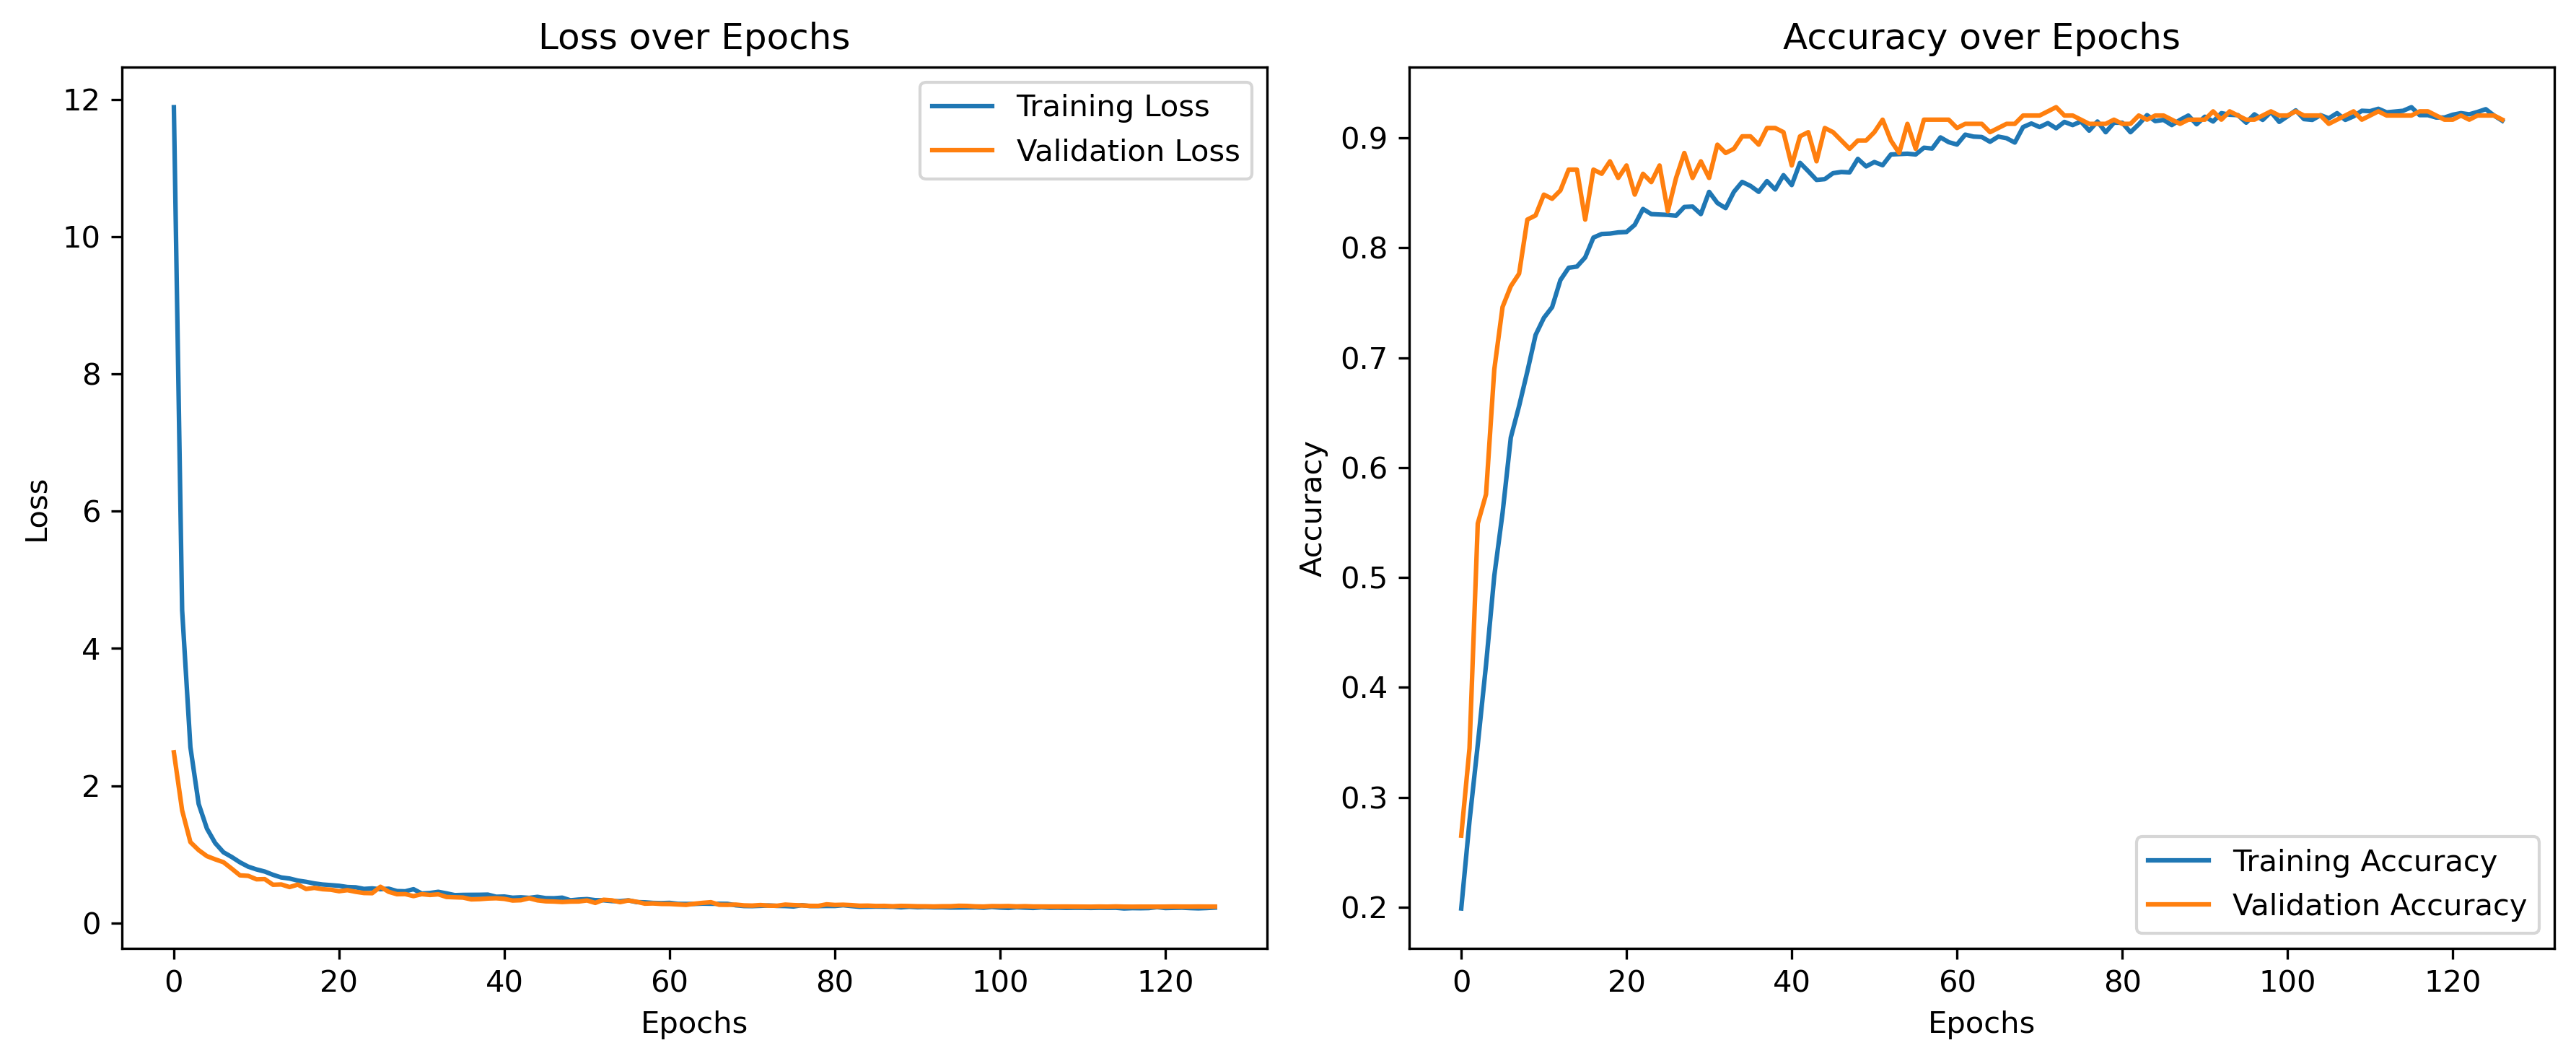

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


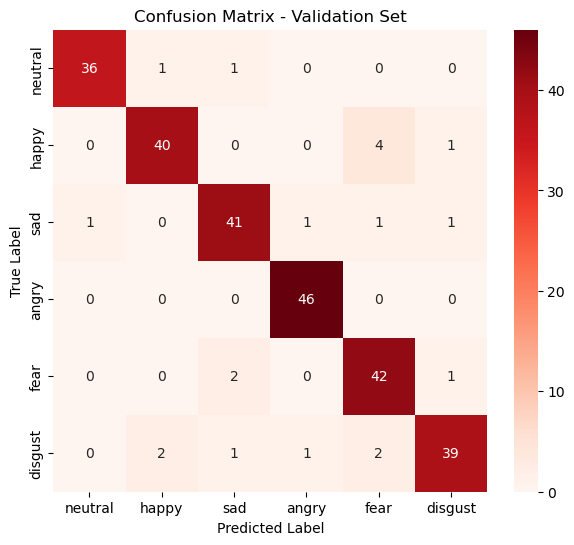

In [81]:
# Plot Training & Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['categorical_accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()



# Predict on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# Define class labels in the correct order
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=range(6))

# Plot Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **OPTUNA FOR TUNING**

In [11]:
BEST_MODEL_PATH = "best_optuna_conv1d_model.keras"

def objective(trial):
    # Hyperparameters
    conv_filters = trial.suggest_categorical('conv_filters', [64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    dense_units = trial.suggest_categorical('dense_units', [128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    epochs = 50

    # Build model
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        Conv1D(conv_filters, kernel_size=kernel_size, activation='relu'),
        Conv1D(conv_filters, kernel_size=kernel_size, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)

    # Epoch-wise training to support pruning
    for epoch in range(epochs):
        history = model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=1,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        val_acc = history.history['val_categorical_accuracy'][-1]
        trial.report(val_acc, step=epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save best model
    if not hasattr(objective, 'best_score') or val_acc > objective.best_score:
        objective.best_score = val_acc
        model.save(BEST_MODEL_PATH)

    return val_acc

In [12]:
pruner = PatientPruner(
    wrapped_pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=5),
    patience=2
)

study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20, show_progress_bar=True)

/var/folders/xt/fyhnj4_s58z0h19vrq6_cq040000gn/T/ipykernel_68491/45620929.py:1: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = PatientPruner(
[I 2025-03-18 21:36:00,660] A new study created in memory with name: no-name-e4cdb6af-2ebb-4cef-ba49-3fe977a7c08f


  0%|          | 0/20 [00:00<?, ?it/s]

2025-03-18 21:36:00.731603: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-18 21:36:00.731800: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-18 21:36:00.731818: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-18 21:36:00.732593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 21:36:00.733080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-18 21:36:01.527712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-03-18 21:36:01.538238: E te

[I 2025-03-18 21:37:32,335] Trial 0 finished with value: 0.9090909361839294 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.22181518901997924, 'learning_rate': 0.00010317255863862885, 'batch_size': 32}. Best is trial 0 with value: 0.9090909361839294.


2025-03-18 21:37:32.853511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:39:35,213] Trial 1 finished with value: 0.9318181872367859 and parameters: {'conv_filters': 128, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.34336433775368536, 'learning_rate': 0.0017161988422306326, 'batch_size': 32}. Best is trial 1 with value: 0.9318181872367859.


2025-03-18 21:39:35.694697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:40:39,703] Trial 2 finished with value: 0.8939393758773804 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dense_units': 256, 'dropout_rate': 0.2573318372581046, 'learning_rate': 0.000867123479125003, 'batch_size': 64}. Best is trial 1 with value: 0.9318181872367859.


2025-03-18 21:40:40.221533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:40:52,678] Trial 3 pruned. 
[I 2025-03-18 21:41:52,459] Trial 4 pruned. 


2025-03-18 21:41:52.865731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:42:57,561] Trial 5 pruned. 


2025-03-18 21:42:58.012747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:44:07,688] Trial 6 finished with value: 0.9242424368858337 and parameters: {'conv_filters': 128, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.3474574866338732, 'learning_rate': 0.0017786585012191465, 'batch_size': 64}. Best is trial 1 with value: 0.9318181872367859.


2025-03-18 21:44:08.187983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:45:30,253] Trial 7 pruned. 


2025-03-18 21:45:30.675350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:47:00,229] Trial 8 finished with value: 0.9318181872367859 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.20304986813873185, 'learning_rate': 0.0015310431951481602, 'batch_size': 64}. Best is trial 1 with value: 0.9318181872367859.


2025-03-18 21:47:02.735098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:47:35,900] Trial 9 pruned. 
[I 2025-03-18 21:48:17,233] Trial 10 pruned. 


2025-03-18 21:48:18.586480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:49:04,484] Trial 11 pruned. 
[I 2025-03-18 21:50:04,287] Trial 12 pruned. 


2025-03-18 21:50:04.846579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:51:06,430] Trial 13 pruned. 


2025-03-18 21:51:07.839360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:52:42,944] Trial 14 pruned. 


2025-03-18 21:52:43.856303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:54:42,652] Trial 15 finished with value: 0.935606062412262 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.23724190308124066, 'learning_rate': 0.0006923206020900397, 'batch_size': 32}. Best is trial 15 with value: 0.935606062412262.


2025-03-18 21:54:43.389191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:55:18,489] Trial 16 pruned. 
[I 2025-03-18 21:57:29,241] Trial 17 finished with value: 0.9280303120613098 and parameters: {'conv_filters': 64, 'kernel_size': 5, 'dense_units': 128, 'dropout_rate': 0.3009922432544093, 'learning_rate': 0.0006820710093654507, 'batch_size': 32}. Best is trial 15 with value: 0.935606062412262.


2025-03-18 21:57:29.958284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


[I 2025-03-18 21:58:21,682] Trial 18 pruned. 
[I 2025-03-18 21:58:54,150] Trial 19 pruned. 



Best trial:
  Accuracy: 0.9356
  Best Hyperparameters:
    conv_filters: 64
    kernel_size: 5
    dense_units: 128
    dropout_rate: 0.23724190308124066
    learning_rate: 0.0006923206020900397
    batch_size: 32
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Test Set Classification Report:
              precision    recall  f1-score   support

     neutral       0.94      1.00      0.97        16
       happy       0.86      0.95      0.90        20
         sad       1.00      0.89      0.94        19
       angry       1.00      0.89      0.94        19
        fear       0.78      0.90      0.84        20
     disgust       0.89      0.80      0.84        20

    accuracy                           0.90       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.90      0.90       114



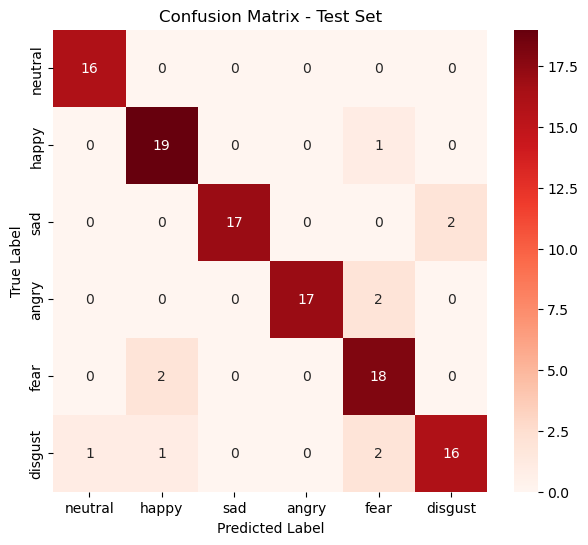

In [14]:
print("\nBest trial:")
print(f"  Accuracy: {study.best_value:.4f}")
print("  Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

best_model = load_model(BEST_MODEL_PATH)
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nTest Set Classification Report:")
print(classification_report(y_true, y_pred, target_names=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'], yticklabels=['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()